In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit


In [2]:
# all filenames
filenames = ['b2d2a.csv', 'b2d2b.csv', 'b2d2c.csv', 'b2d2d.csv',
                 'b2d3b.csv', 'b2d3c.csv', 'b2d3d.csv',
                 'b2d4a.csv', 'b2d4b.csv', 'b2d4c.csv', 'b2d4d.csv',
                 'b2d5a.csv', 'b2d5b.csv', 'b2d5c.csv', 'b2d5d.csv',
                 'b2d6a.csv', 'b2d6b.csv', 'b2d6c.csv', 'b2d6d.csv',]

# functional gate filenames
filenames = ['b2d2b.csv', 'b2d2c.csv',
                 'b2d3b.csv', 'b2d3c.csv', 'b2d3d.csv',
                 'b2d4a.csv', 'b2d4b.csv', 'b2d4d.csv',
                 'b2d6a.csv', 'b2d6b.csv', 'b2d6c.csv', 'b2d6d.csv',]

# data_folder = '\\c\\Users\\joeyl\\Downloads\\GFET-covid-flu\\Akinwande-lab-measurements\\data\\data_1-27-25\\'
data_folder = 'data_1-27-25/'

# info about devices
# device num // channel length (um)
# b2d2 200
# b2d3 100
# b2d4 400
# b2d5 400
# b2d6 100

channel_lengths = {'b2d1': 200, 
                   'b2d2': 200, 
                   'b2d3': 100, 
                   'b2d4': 400, 
                   'b2d5': 400, 
                   'b2d6': 100}
channel_colors = {100: 'limegreen', 200: 'blue', 400: 'red'}

channel_length_indices = {100: [1,4], 200: [0], 400: [2,3]}

In [3]:
def load_csv_data(filenames):
    '''
    returns: np mx of all data, and header
    '''
    data_list = []
    for filename in filenames:
        data_device = np.loadtxt(data_folder + filename, delimiter=',', skiprows=1).T
        header = np.loadtxt(data_folder + filename, delimiter=",", dtype=str, max_rows=1)
        data_list.append(data_device)
    data = np.array(data_list)
    return data, header

data, header = load_csv_data(filenames)
data = data[:,:,:data.shape[2]//2]
print(header)
print(data.shape)

['Repeat' 'VAR2' 'Point' 'CH1 Voltage' 'CH1 Current' 'CH1 Time'
 'CH2__GATE Voltage' 'CH2__GATE Current' 'CH2__GATE Time']
(12, 9, 200)


In [4]:
def get_data_drain_iv(data):
    return data[:,[6,4], :]

def get_data_gate_iv(data):
    return data[:,[6,7], :]

data_drain_iv = get_data_drain_iv(data)
print(data_drain_iv.shape)

data_gate_iv = get_data_gate_iv(data)
print(data_gate_iv.shape)


(12, 2, 200)
(12, 2, 200)


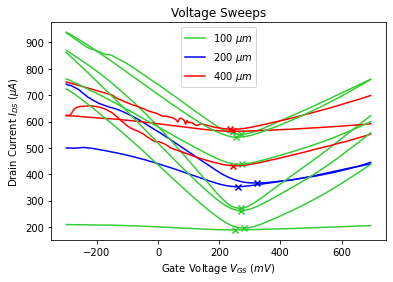

In [5]:
# plot the data
def plot_data_iv(data_drain_iv, filenames):

    for gate_num in range(len(filenames)):
        channel_length = channel_lengths[filenames[gate_num][:4]]
        color = channel_colors[channel_length]
        plt.plot(data_drain_iv[gate_num,0] * 1000.0, data_drain_iv[gate_num,1] * 1000000.0, color=color, label = str(channel_length) + r' $\mu m$')

        # plotting dirac points
        x_idx = np.argmin(data_drain_iv[gate_num,1,:], axis=-1)
        y = np.min(data_drain_iv[gate_num,1,:], axis=-1)
        x = data_drain_iv[0,0,:][x_idx]
        plt.scatter(x * 1000.0, y * 1000000.0, color=color, marker='x')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    unique = {}
    for handle, label in zip(handles, labels):
        if label not in unique:
            unique[label] = handle
    sorted_unique = dict(sorted(unique.items(), key=lambda x: x[0]))
    plt.legend(sorted_unique.values(), sorted_unique.keys())
    
    plt.title('Voltage Sweeps')
    plt.xlabel(r'Gate Voltage $V_{GS}$ $(mV)$')
    plt.ylabel(r'Drain Current $I_{DS}$ $(\mu A)$')
    plt.show()
    plt.close()

plot_data_iv(data_drain_iv, filenames)

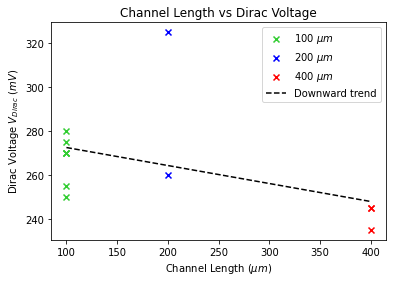

In [6]:
# calculates dirac points and analyze trend with channel length

def dirac_points_stats(data_drain_iv, filenames):

    dirac_channel_lengths = []
    dirac_vs = []
    
    for gate_num in range(len(filenames)):
        channel_length = channel_lengths[filenames[gate_num][:4]]
        color = channel_colors[channel_length]
        dirac_v_idx = np.argmin(data_drain_iv[gate_num,1,:], axis=-1)
        dirac_v = data_drain_iv[0,0,:][dirac_v_idx]
        dirac_channel_lengths.append(channel_length)
        dirac_vs.append(dirac_v * 1000.0)
        plt.scatter(channel_length, dirac_v * 1000.0, color=color, marker='x', label=str(channel_length)+r' $\mu m$')

    dirac_channel_lengths = np.array(dirac_channel_lengths)
    dirac_vs = np.array(dirac_vs)
    coeffs = np.polyfit(dirac_channel_lengths, dirac_vs, 1)
    poly_eq = np.poly1d(coeffs)
    x_fit = np.linspace(min(dirac_channel_lengths), max(dirac_channel_lengths), 100)
    y_fit = poly_eq(x_fit)
    plt.plot(x_fit, y_fit, linestyle="--", color="black", label="Downward trend")
        
    handles, labels = plt.gca().get_legend_handles_labels()
    unique = {}
    for handle, label in zip(handles, labels):
        if label not in unique:
            unique[label] = handle
    sorted_unique = dict(sorted(unique.items(), key=lambda x: x[0]))
    plt.legend(sorted_unique.values(), sorted_unique.keys())
    
    plt.title('Channel Length vs Dirac Voltage')
    plt.xlabel(r'Channel Length $(\mu m)$')
    plt.ylabel(r'Dirac Voltage $V_{Dirac}$ $(mV)$')
    plt.show()
    plt.close()
        

dirac_points_stats(data_drain_iv, filenames)

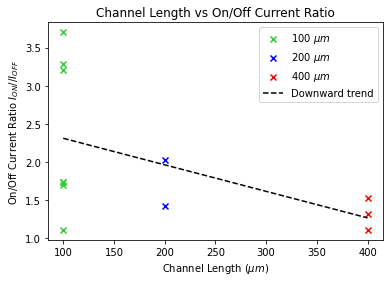

In [7]:
# calculate on/off current ratio and analyze wrt channel length

def onoff_ratio_stats(data_drain_iv, filenames):

    onoff_channel_lengths = []
    onoff_ratios = []
    
    for gate_num in range(len(filenames)):
        channel_length = channel_lengths[filenames[gate_num][:4]]
        color = channel_colors[channel_length]

        onoff_ratio = np.max(data_drain_iv[gate_num,1,:], axis=-1) / np.min(data_drain_iv[gate_num,1,:], axis=-1)
        onoff_channel_lengths.append(channel_length)
        onoff_ratios.append(onoff_ratio)
        
        plt.scatter(channel_length, onoff_ratio, color=color, marker='x', label=str(channel_length)+r' $\mu m$')

    onoff_channel_lengths = np.array(onoff_channel_lengths)
    onoff_ratios = np.array(onoff_ratios)
    coeffs = np.polyfit(onoff_channel_lengths, onoff_ratios, 1)
    poly_eq = np.poly1d(coeffs)
    x_fit = np.linspace(min(onoff_channel_lengths), max(onoff_channel_lengths), 100)
    y_fit = poly_eq(x_fit)
    plt.plot(x_fit, y_fit, linestyle="--", color="black", label="Downward trend")
        
    handles, labels = plt.gca().get_legend_handles_labels()
    unique = {}
    for handle, label in zip(handles, labels):
        if label not in unique:
            unique[label] = handle
    sorted_unique = dict(sorted(unique.items(), key=lambda x: x[0]))
    plt.legend(sorted_unique.values(), sorted_unique.keys())
    plt.title('Channel Length vs On/Off Current Ratio')
    plt.xlabel(r'Channel Length $(\mu m)$')
    plt.ylabel(r'On/Off Current Ratio $I_{ON} // I_{OFF}$')
    plt.show()
    plt.close()
        

onoff_ratio_stats(data_drain_iv, filenames)

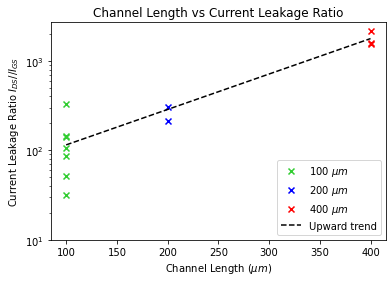

In [8]:
# gate leakage current ratio

# gate current: max or dirac
# drain current: max or dirac
# here: dirac gate current and dirac drain current

# calculate on/off current ratio and analyze wrt channel length

def exp_func(x, a, b):
    return a * np.exp(b * x)

def gate_current_leakage_ratio_stats(data_drain_iv, data_gate_iv, filenames):

    leakage_channel_lengths = []
    leakage_ratios = []
    
    for gate_num in range(len(filenames)):
        channel_length = channel_lengths[filenames[gate_num][:4]]
        color = channel_colors[channel_length]

        dirac_v_idx = np.argmin(data_drain_iv[gate_num,1,:], axis=-1)
        gate_leakage_i = data_gate_iv[gate_num,1,:][dirac_v_idx]
        drain_i = np.min(data_drain_iv[gate_num,1,:], axis=-1)

        leakage_ratio = drain_i / gate_leakage_i
        leakage_channel_lengths.append(channel_length)
        leakage_ratios.append(leakage_ratio)
        
        plt.scatter(channel_length, leakage_ratio, color=color, marker='x', label=str(channel_length)+r' $\mu m$')

    leakage_channel_lengths = np.array(leakage_channel_lengths)
    leakage_ratios = np.array(leakage_ratios)
    coeffs, _ = curve_fit(exp_func, leakage_channel_lengths, leakage_ratios, p0=(np.min(leakage_ratios), 0.1))
    x_fit = np.linspace(min(leakage_channel_lengths), max(leakage_channel_lengths), 100)
    y_fit = exp_func(x_fit, *coeffs)
    plt.plot(x_fit, y_fit, linestyle="--", color="black", label="Upward trend")
    
        
    handles, labels = plt.gca().get_legend_handles_labels()
    unique = {}
    for handle, label in zip(handles, labels):
        if label not in unique:
            unique[label] = handle
    sorted_unique = dict(sorted(unique.items(), key=lambda x: x[0]))
    plt.legend(sorted_unique.values(), sorted_unique.keys(), loc='lower right')
    plt.title('Channel Length vs Current Leakage Ratio')
    plt.xlabel(r'Channel Length $(\mu m)$')
    plt.ylabel(r'Current Leakage Ratio $I_{DS} // I_{GS}$')
    plt.yscale('log')
    plt.ylim(10, None)
    plt.show()
    plt.close()
        
gate_current_leakage_ratio_stats(data_drain_iv, data_gate_iv, filenames)